In [9]:
library(fastDummies)
library(cplm)
library(tweedie)
library(statmod)
library(HDtweedie)
library(TDboost)
library(mgcv)
library(MASS)
library(glmnet)

In [249]:
x1<-runif(10000,2,8)
x2<-runif(10000,-10,1)
x3<-runif(10000,-2,0)
b_t<-runif(4,-2,1)
design_x <- as.matrix(cbind(x1,x2,x3,x1*x2))
colnames(design_x) <- c('x1','x2','x3','x1:x2')
mu<-exp(design_x%*%b_t)
summary(mu)

       V1          
 Min.   :  0.1266  
 1st Qu.:  1.3828  
 Median :  4.1281  
 Mean   : 23.2231  
 3rd Qu.: 14.6926  
 Max.   :729.0415  

In [252]:
y_sim<- rTweedie(mu,p=1.5,phi=10)
length(which(y_sim==0))

[1] 6071

In [253]:
dd<-as.data.frame(cbind(design_x[,1:3],y_sim))

---
 This function may take some time to complete;
 Please be patient.  If it fails, try using  method="series"
 rather than the default  method="inversion"
 Another possible reason for failure is the range of p:
 Try a different input for  p.vec
---


Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"


1.2 1.3 1.4 1.5 1.6 1.7 1.8 
xi = 1.2
* Fitting initial model: Done
* Phi estimation, method:  mle (using optimize):  Done (phi = 0.2629851 )
* Computing the log-likelihood (method = series ): Done: L = -1928.991 
xi = 1.3
* Fitting initial model: Done
* Phi estimation, method:  mle (using optimize):  Done (phi = 0.4764082 )
* Computing the log-likelihood (method = series ): Done: L = -1338.365 
xi = 1.4
* Fitting initial model: Done
* Phi estimation, method:  mle (using optimize):  Done (phi = 0.8372583 )
* Computing the log-likelihood (method = series ): Done: L = -1098.649 
xi = 1.5
* Fitting initial model: Done
* Phi estimation, method:  mle (using optimize):  Done (phi = 1.50644 )
* Computing the log-likelihood (method = series ): Done: L = -1040.031 
xi = 1.6
* Fitting initial model: Done
* Phi estimation, method:  mle (using optimize):  Done (phi = 2.901584 )
* Computing the log-likelihood (method = series ): Done: L = -1108.18 
xi = 1.7
* Fitting initial model: Done
* Phi estim

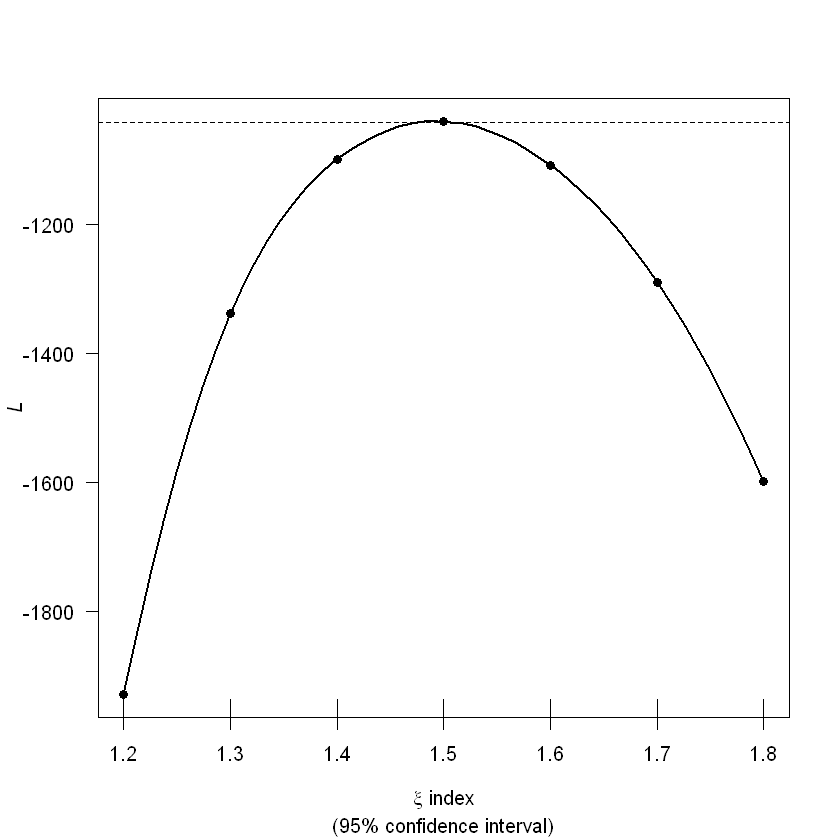

In [235]:
# est_p <-tweedie.profile(y_sim~x1+x2+x3+x1*x2-1,data=dd,
#                         method='series',verbose=2,
#                         link.power = 0,do.smooth = TRUE, do.plot = TRUE)

In [254]:
sam <- sample(rep(1:2,len=10000))

In [255]:
sim_train<-dd[sam==1,]
sim_test<-dd[sam==2,]

In [256]:
sim_train<-as.data.frame(sim_train)
sim_test<-as.data.frame(sim_test)

In [257]:
colnames(sim_train)[4]='y'
colnames(sim_test)[4]='y'

In [258]:
head(sim_train)

,x1,x2,x3,y
,<dbl>,<dbl>,<dbl>,<dbl>
1,4.511052,-6.271984,-0.2453881,0
4,2.017875,-9.340325,-1.8154807,0
8,7.821450,-8.574359,-0.4245308,0
14,2.639772,-5.001531,-0.3911517,0
18,2.600786,-8.106091,-0.2245491,0
19,2.682553,-3.699548,-0.5979809,0


In [259]:
fit1<-glm(y~.+x1*x2-1,data=sim_train,family=tweedie(link.power=0,var.power=1.5))
summary(fit1)
mean(residuals(fit1)^2)
b_t


Call:
glm(formula = y ~ . + x1 * x2 - 1, family = tweedie(link.power = 0, 
    var.power = 1.5), data = sim_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.6481  -2.7657  -1.9803  -0.1248  10.6119  

Coefficients:
       Estimate Std. Error t value Pr(>|t|)    
x1     0.688780   0.008570  80.369   <2e-16 ***
x2    -0.004423   0.023973  -0.185    0.854    
x3    -0.349785   0.040110  -8.721   <2e-16 ***
x1:x2  0.098069   0.004512  21.736   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Tweedie family taken to be 10.08719)

    Null deviance: 392277  on 5000  degrees of freedom
Residual deviance:  39637  on 4996  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 5


[1] 7.92747

[1]  0.69840549 -0.01584871 -0.28828343  0.10006808

In [260]:
#Initial: For example, we can use the least square estimates or the simple regression estimates by regressing the response y on each of the terms.
# Main effects
fit_b1<-glm(y~x1-1,data=sim_train,family=tweedie(link.power=0,var.power=1.5),control=list(maxit=500))
b1_0 <- fit_b1$coefficients

fit_b2<-glm(y~x2-1,data=sim_train,family=tweedie(link.power=0,var.power=1.5),control=list(maxit=500))
b2_0 <- fit_b2$coefficients

fit_b3<-glm(y~x3-1,data=sim_train,family=tweedie(link.power=0,var.power=1.5))
b3_0 <- fit_b3$coefficients

In [261]:
#Interaction: when update r12, use y~b1b2x1x2 with no intercept.
effect_12<-b1_0*b2_0*sim_train$x1*sim_train$x2
fit_r12<-glm(sim_train$y~effect_12-1,family=tweedie(link.power=0,var.power=1.5),control=list(maxit=500))
r12_0<-fit_r12$coefficients

effect_13<-b1_0*b3_0*sim_train$x1*sim_train$x3
fit_r13<-glm(sim_train$y~effect_13-1,family=tweedie(link.power=0,var.power=1.5),control=list(maxit=500))
r13_0<-fit_r13$coefficients

effect_23<-b1_0*b2_0*sim_train$x2*sim_train$x3
fit_r23<-glm(sim_train$y~effect_23-1,family=tweedie(link.power=0,var.power=1.5),control=list(maxit=500))
r23_0<-fit_r23$coefficients

In [262]:
b1_0
b2_0
b3_0
r12_0
r13_0
r23_0

x1 
0.5436646

x2 
-0.1970621

x3 
-2.388111

effect_12 
0.3325976

effect_13 
 0.318498

effect_23 
-1.478138

In [263]:
X1<-sim_train$x1
X2<-sim_train$x2
X3<-sim_train$x3

In [264]:
w<-rep(1, 2500)
sx<-cbind(X1,X2,X3)#,X1*X2,X1*X3,X2*X3
sy<-sim_train$y
lambda.max <- max(abs(colSums(sy * sx))) / nrow(sx)
lambda.factor = 1e-06
nlambda = 100
lamb<-rev(exp(seq(log(lambda.factor * lambda.max), log(lambda.max), length.out = nlambda)))

In [265]:
base<-glmnet(x=sx, y=sy,family=tweedie(link.power=0,var.power=1.7),intercept=FALSE,control=list(maxit=500))
lambb<-base$lambda

In [266]:
#Update r: y~r12 (b1b2x1x2+r13b1b3x1x3+r23b2b3x2x3)+ offset [b1x1+b2x2+b3x3]
#offset:
offset_r_1<-b1_0*X1+b2_0*X2+b3_0*X3

In [267]:
effect_1_matrix<- as.matrix(cbind(effect_12,effect_13,effect_23))

In [273]:
#Use lambda from r12 as candidate
r12_1_fit<-glmnet(x=effect_1_matrix,y=sim_train$y,family=tweedie(link.power=0,var.power=1.5),offset=offset_r_1,intercept=FALSE,lambda=lambb[20])

In [274]:
r_update<-coef(r12_1_fit)[,1]
r_update_1<-r_update[2:length(r_update)]
r_update_1

effect_12  effect_13  effect_23 
-0.1641074 -0.1714525  0.0000000

In [275]:
r_update<-function(beta,power,y,X,lambda){
    offset=as.matrix(X)%*%beta
    n<-length(beta)
    design_matrix<-c()
    index<-combn(c(1:n),m=2)
    for (i in 1:n){
        beta_tmp<-beta[index[1,i]]*beta[index[2,i]]
        design_matrix<-cbind(design_matrix,beta_tmp*X[,index[1,i]]*X[,index[2,i]]  )
    }
    r_fit<-glmnet(x=design_matrix,y=y,family=tweedie(link.power=0,var.power=power),offset=offset,intercept=FALSE,lambda=lambda)
    return(coef(r12_1_fit)[-1,1])
}

In [276]:
beta_0_t<-c(b1_0, b2_0, b3_0)

In [277]:
r_update(beta_0_t,power=1.5,y=sim_train$y,X=sim_train[,1:3],lambda=lambb[20])

effect_12  effect_13  effect_23 
-0.1641074 -0.1714525  0.0000000

In [278]:
#Update b1. To note design matrix is (0, x1)
offset_b1<-b2_0*X2+b3_0*X3+b2_0*b3_0*X2*X3
b1_x1<-X1+r_update_1[1]*b2_0*X1*X2+r_update_1[2]*b3_0*X1*X3
b1_matrix <- (as.matrix(cbind(0,b1_x1)))
b1_1_fit<-glmnet(x=b1_matrix,y=sim_train$y,family=tweedie(link.power=0,var.power=1.5)
                    ,offset=offset_b1,intercept=FALSE,lambda=lambb[20],control=list(maxit=500))
b1_update<-coef(b1_1_fit)[,1]
b1_update_1<-b1_update[3]

In [279]:
#Update b2
offset_b2<-b1_update_1*X1+b3_0*X3+b1_update_1*b3_0*X1*X3
b2_x1<-X2+r_update_1[1]*b1_update_1*X1*X2+r_update_1[3]*b3_0*X2*X3
b2_matrix <- as.matrix(cbind(0,b2_x1))
b2_1_fit<-glmnet(x=b2_matrix,y=sim_train$y,family=tweedie(link.power=0,var.power=1.5)
                    ,offset=offset_b2,intercept=FALSE,lambda=lambb[20],control=list(maxit=500))
b2_update<-coef(b2_1_fit)[,1]
b2_update_1<-b2_update[3]

In [285]:
offset_b3<-b1_update_1*X1+b2_update_1*X2+b1_update_1*b2_update_1*X1*X2
b3_x1<-X3+r_update_1[2]*b1_update_1*X1*X3+r_update_1[3]*b2_update_1*X2*X3
b3_matrix <- as.matrix(cbind(0,b3_x1))
b3_1_fit<-glmnet(x=b3_matrix,y=sim_train$y,family=tweedie(link.power=0,var.power=1.5)
                    ,offset=offset_b3,intercept=FALSE,lambda=lambb[20],control=list(maxit=500))
b3_update<-coef(b3_1_fit)[,1]
b3_update_1<-b3_update[3]

In [281]:
beta_update <- function(beta,r,power,y,X,lambda){
    n_beta = length(beta)
    beta_update_result<-c()
    for (i in 1:n_beta){
        X_i<-X[,-i]
        X_i_m <- model.matrix(~.^2-1, data=X_i)
        beta_i<-beta[-i]
        beta_i_m<-beta_comb(beta_i)
        tmp_offset<-X_i_m%*%beta_i_m
        index_r<-which(apply(combn(c(1:n_beta),m=2), 2,function(x) i %in% x))            
        coefficient_r<-r[index_r]*beta_i
        X_matrix_0<-as.matrix(X_i*X[,i])
        b_matrix_0<-X[,i]+X_matrix_0%*%coefficient_r
        b_matrix_1<- as.matrix(cbind(0, b_matrix_0))
        b_fit<-glmnet(x=b_matrix_1,y=y,family=tweedie(link.power=0,var.power=power)
                    ,offset=tmp_offset,intercept=FALSE,lambda=lambda,control=list(maxit=500))
        b_update_tmp<-coef(b_fit)[3,1]
        beta_update_result<-c(beta_update_result,b_update_tmp)
        beta[i]<-b_update_tmp
    }
    
    return(beta_update_result)
}

In [286]:
beta_update(beta_0_t,r_update_1,power=1.5,y=sim_train$y,X=sim_train[,1:3],lambda=lambb[20])

[1]  0.000000  0.000000 -1.315241

In [283]:
b_update_1<-c(b1_update_1,b2_update_1,b3_update_1)

In [284]:
b_update_1

b1_x1     b2_x1     b3_x1 
 0.000000  0.000000 -2.375832

In [287]:
X<-as.matrix(cbind(X1,X2,X3))

In [298]:
r_0_t<-c(r12_0,r13_0,r23_0)

In [300]:
fitted_0<-exp(X%*%beta_0_t+ r_0_t[1]*beta_0_t[1]*beta_0_t[2]*X1*X2 +r_0_t[2]*beta_0_t[1]*beta_0_t[3]*X1*X3+r_0_t[3]*beta_0_t[2]*beta_0_t[3]*X2*X3)

In [288]:
fitted_1 <- exp(X%*%b_update_1 + r_update_1[1]*b_update_1[1]*b_update_1[2]*X1*X2 +r_update_1[2]*b_update_1[1]*b_update_1[3]*X1*X3+r_update_1[3]*b_update_1[2]*b_update_1[3]*X2*X3)

In [289]:
ytrain<-sim_train$y

In [303]:
abs(Q(ytrain,fitted_0,1.5,lambb[20],r_0_t,beta_0_t)-Q(ytrain,fitted_1,1.5,lambb[20],r_update_1,b_update_1))/abs(Q(ytrain,fitted_0,1.5,lambb[20],r_0_t,beta_0_t))

[1] 0.3048422

In [293]:
Q<-function(y,mu,power,lamb,r,b){
    den<-dtweedie(y=y,mu=mu,phi=sum(tweedie.dev(y=y,mu=mu,power=power))/length(y),power=power)
    Q<--sum(log(den))+sum(abs(r))*lamb+sum(abs(b))*lamb
    return(Q)
}

In [125]:
beta_comb<-function(beta){
    n=length(beta)
    if (n>2){
    index=combn(c(1:n),2)
    count=1
    comb_result=c()
    while (count<=n){
        comb_result=c(comb_result,beta[index[1,count]]*beta[index[2,count]])
        count=count+1
    }
    return(c(beta,comb_result))}
    else{
        index=combn(c(1:n),2)
        comb_result=c()
        comb_result=c(comb_result,beta[index[1,1]]*beta[index[2,1]])
        return(c(beta,comb_result))
    }
}

In [305]:
r_update_2<-r_update(b_update_1,power=1.5,y=sim_train$y,X=sim_train[,1:3],lambda=lambb[20])


ERROR: Error in glmnet.path(x, y, weights, lambda, nlambda, lambda.min.ratio, : All used predictors have zero variance


In [307]:
b_update_2<-beta_update(b_update_1,r_update_1,power=1.5,y=sim_train$y,X=sim_train[,1:3],lambda=lambb[20])

In [308]:
b_update_2

[1]  0.01798222  0.00000000 -1.24706548

In [309]:
r_update_1

effect_12  effect_13  effect_23 
-0.1641074 -0.1714525  0.0000000